# Weather Image Classification

In this notebook, a simple CNN model will be used to classify weather images using the training dataset found on https://data.mendeley.com/datasets/4drtyfjtfy/1

**Importing packages**

In [4]:
import os

import tensorflow as tf
import numpy as np

from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import Model
import random

**Unzipping training dataset**

"Dataset" is a single folder containing all images. Before training, dataset.zip needs to be uploaded onto the '/tmp' directory of the colab environment. 

In [2]:
import os
import zipfile

local_zip = '/tmp/dataset.zip'


from zipfile import ZipFile
file_name = local_zip

with ZipFile(file_name, 'r') as zip:
  zip.extractall('/tmp')
  print('Done')



Done


# Data Sorting
As the training dataset contains images of all classes in a single folder, dataset needs to be organised by creating a folder for each label. 

Furthermore, dataset needs to be split into training, validation and test sets with a data split of 90%, 7% and 3% respectively

In [5]:
class_names = ['cloudy','rain','shine','sunrise'] #Dataset Labels

unsorted_data_dir = '/tmp/dataset' #Path to unsorted dataset 
image_list = os.listdir(unsorted_data_dir) #list of all images in the dataset

random.shuffle(image_list) #Shuffling dataset to ensure training, validation and test sets contain similar quantities of each label

total_data_length = len(image_list) 

training_data_index = int(0.9*total_data_length) #Index signifying end of training dataset 
validation_data_index = int(0.97*total_data_length) #Index signifying end of validation dataset 



In [6]:
#Creating Training Data Directory 

train_dir = '/tmp/Training' #training directory path
os.mkdir(train_dir) #creating training directory 

for label in class_names:
    label_dir = train_dir + '/' + label
    os.mkdir(label_dir) #creating subfolders for each label

    for i in range(0,training_data_index): 
    
      img_name = image_list[i]

      if label in img_name:
        img_path = '/tmp/dataset/' + img_name 
        new_img_path = label_dir + '/' + img_name
        os.rename(img_path,new_img_path) #moving image from unsorted to sorted dataset

In [7]:
#Creating Validation Data Directory 

validation_dir = '/tmp/Validation'
os.mkdir(validation_dir)

for label in class_names:
    label_dir = validation_dir + '/' + label
    os.mkdir(label_dir)

    for i in range(training_data_index,validation_data_index): 
    
      img_name = image_list[i]

      if label in img_name:
        img_path = '/tmp/dataset/' + img_name
        new_img_path = label_dir + '/' + img_name
        os.rename(img_path,new_img_path)

In [8]:
#Creating Testing Data Directory 

test_dir = '/tmp/Test'
os.mkdir(test_dir)

for label in class_names:
    label_dir = test_dir + '/' + label
    os.mkdir(label_dir)

    for i in range(validation_data_index,total_data_length): 
    
      img_name = image_list[i]

      if label in img_name:
        img_path = '/tmp/dataset/' + img_name
        new_img_path = label_dir + '/' + img_name
        os.rename(img_path,new_img_path)

# Image Data Preprocessing using Keras ImageDataGenerator

ImageDataGenerator package in Keras allows for easy preprocessing of image data, where it automatically accounts for variations in image sizes and aspect ratio and allows for easy data augmentation. 

For this task, a target image size of 300x300 pixels was selected as a compromise between training computational cost and accuracy. 

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale = 1./255. )
                                 # ,rotation_range = 40,
                                  # width_shift_range = 0.2,
                                  # height_shift_range = 0.2,
                                  # shear_range = 0.2,
                                  # zoom_range = 0.2,
                                  # horizontal_flip = True)



test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (300, 300))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (300, 300))

Found 1012 images belonging to 4 classes.
Found 79 images belonging to 4 classes.


# Model Definition and Training

A CNN architecture with 4 convolutional layers and two dense layers was used. The model is trained entirely from scratch using the training data provided - better accuracy could perhaps be obtained using pre-trained models however due to time contstraints these were not considered. 

It is important to note that this is a basic model with a lot of room for further tuning (number of convolutional layers, number of filters in each layer, etc., batch size, learning rate, optimiser, etc.) 

In [55]:
model = tf.keras.models.Sequential([
    
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax') #Four neurons and a softmax activation for output probabilities
])

In [56]:
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 147, 147, 64)      36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 33, 33, 128)      

In [57]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            #steps_per_epoch = 50,
            epochs = 20,
           # validation_steps = 50,
            verbose = 1)

Epoch 1/20
51/51 [==============================] - 9s 169ms/step - loss: 3.7559 - accuracy: 0.3480 - val_loss: 0.7417 - val_accuracy: 0.8481
Epoch 2/20
51/51 [==============================] - 9s 168ms/step - loss: 0.8443 - accuracy: 0.6787 - val_loss: 0.4785 - val_accuracy: 0.8734
Epoch 3/20
51/51 [==============================] - 9s 169ms/step - loss: 0.6951 - accuracy: 0.7309 - val_loss: 0.4898 - val_accuracy: 0.8101
Epoch 4/20
51/51 [==============================] - 9s 171ms/step - loss: 0.5089 - accuracy: 0.7895 - val_loss: 0.5920 - val_accuracy: 0.8481
Epoch 5/20
51/51 [==============================] - 9s 168ms/step - loss: 0.6113 - accuracy: 0.7853 - val_loss: 0.4988 - val_accuracy: 0.8608
Epoch 6/20
51/51 [==============================] - 9s 169ms/step - loss: 0.5341 - accuracy: 0.8272 - val_loss: 0.4204 - val_accuracy: 0.8734
Epoch 7/20
51/51 [==============================] - 9s 165ms/step - loss: 0.3766 - accuracy: 0.8458 - val_loss: 0.3845 - val_accuracy: 0.9241
Epoch 

**Visualising Training and Validation accuracy**

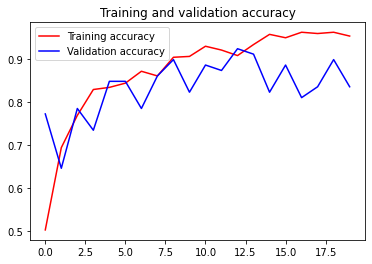

<Figure size 432x288 with 0 Axes>

In [51]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# Evaluating Model Performance



In [58]:
#Initialising variables and lists to calculate accuracy

true_labels = []
pred_labels = []

correct = 0
total = 0

for label in class_names: #Opening images by label 
    label_dir = test_dir + '/' + label

    image_list = os.listdir(label_dir)

    for img_name in image_list:
      img_path = label_dir + '/' + img_name

      img = keras.preprocessing.image.load_img(
      img_path, target_size=(300, 300))

      img_array = keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) 

      prediction = model.predict(img_array)

      true_labels.append(label)
      pred_labels.append(class_names[np.argmax(prediction)])

      if class_names[np.argmax(prediction)] == label:
          correct +=1 #Counter for correct classifications

      total +=1 

      #print(
      #img_name + " most likely belongs to {} with a {:.2f} percent confidence."
      #.format(class_names[np.argmax(prediction)], 100 * np.max(prediction)))

print('Test Accuracy is {:.2f}%'.format(100*correct/total))

cloudy258.jpg most likely belongs to rain with a 100.00 percent confidence.
cloudy166.jpg most likely belongs to sunrise with a 100.00 percent confidence.
cloudy73.jpg most likely belongs to cloudy with a 100.00 percent confidence.
cloudy97.jpg most likely belongs to cloudy with a 100.00 percent confidence.
cloudy119.jpg most likely belongs to shine with a 100.00 percent confidence.
cloudy181.jpg most likely belongs to cloudy with a 100.00 percent confidence.
cloudy126.jpg most likely belongs to shine with a 100.00 percent confidence.
rain13.jpg most likely belongs to rain with a 100.00 percent confidence.
rain185.jpg most likely belongs to rain with a 100.00 percent confidence.
rain69.jpg most likely belongs to rain with a 100.00 percent confidence.
rain82.jpg most likely belongs to rain with a 100.00 percent confidence.
rain206.jpg most likely belongs to rain with a 100.00 percent confidence.
rain127.jpg most likely belongs to rain with a 100.00 percent confidence.
shine150.jpg most 

**Confusion Matrix**

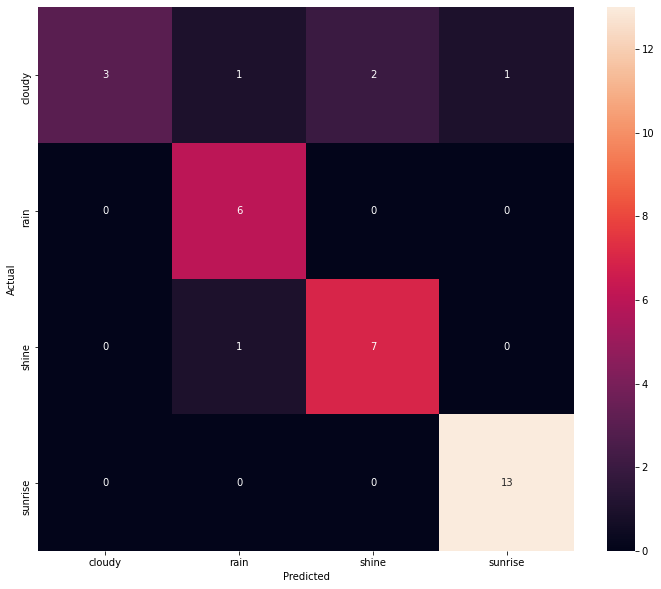

In [60]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    true_labels,
        'y_Predicted': pred_labels
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

fig_dims = (12, 10)
fig, ax = plt.subplots(figsize=fig_dims)

sn.heatmap(confusion_matrix, annot=True, ax = ax)
plt.show()

# Section for user to upload and classify images 

In [27]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
 
  img_path = '/content/' + fn
  
  img = keras.preprocessing.image.load_img(
  img_path, target_size=(300, 300))

  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) 

  prediction = model.predict(img_array)
  

  print(
      fn + " most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(prediction)], 100 * np.max(prediction)))


Saving cloudy255.jpg to cloudy255 (1).jpg
cloudy255.jpg most likely belongs to cloudy with a 100.00 percent confidence.
